In [0]:
### WBGPS analysis functions
from wbgps.analysis import compute_rural_migration_stats_city
my_palette = sns.color_palette(['#ce343c','#EC8A61', '#89d4b4','#0081A7', '#72C9C8', '#547474', '#8a567a', '#743D55','#b25a97', '#efb953'])

In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

import pyspark.sql.functions as F
from pyspark.sql.functions import col, desc, lit
from pyspark.sql import Window

spark.conf.set("spark.sql.shuffle.partitions", 1500)

start_baseline = '2020-02-01'
end_baseline = '2020-03-01'
start_date = '2020-02-01'
end_date = '2021-04-15'

results_dir = '/dbfs/mnt/Geospatial/results/veraset/'
admin_path = f'/mnt/Geospatial/admin/' # country specific admin files should be stored as "{admin_path}/{country}/admin.csv"
stop_path = '/mnt/Geospatial/results/veraset/'

bins_wealth = [0, 0.4, 0.8, 1]
bins_dist = [0, 0.4, 0.8, 1]

countries = ['ID', 'PH', 'BR', 'CO', 'MX', 'ZA']
# countries = ['PH']

c_dates = {'BR': '2021-05-16',
           'CO': '2021-05-16',
           'ID': '2021-05-16',
           'MX': '2021-05-16',
           'PH': '2021-05-16',
           'ZA': '2021-05-16',
           'AR': '2021-05-16'}

activity_level = 0.2

hw = 49
ww = 49
wa = 3600
mph = 0.2
mpw = 0.2

# Smoothing size for mobility
ma = 28
# Smoothing size for migrations
mw = 28

labels_wealth = [x+' ('+str(int(bins_wealth[i]*100))+'%-'+str(int(bins_wealth[i+1]*100)) +'%)' for i, x in zip(range(len(bins_wealth)-1), ['Low', 'Medium', 'High'])]
labels_dist = [x+' ('+str(int(bins_dist[i]*100))+'%-'+str(int(bins_dist[i+1]*100)) +'%)' for i, x in zip(range(len(bins_dist)-1), ['Low', 'Medium', 'High'])]
country_capitals = {'MX': 'Mexico City', 'BR': 'São Paulo', 'CO': 'Bogota',
                    'PH': 'Quezon City [Manila]', 'ID': 'Jakarta', 'ZA': 'Johannesburg', 'AR': 'GBuenos Aires'}

In [0]:
# df_wl = pd.DataFrame()
# usr_df = pd.DataFrame()
# for country in countries:
#     print(country)
#     out, usrs = compute_rural_migration_stats_city(country, bins_wealth, labels_wealth, hw, ww, wa, mph, mpw, activity_level, c_dates, admin_path, stop_path)
#     usr_df = pd.concat([usr_df, usrs])
#     df_wl = pd.concat([df_wl, out], sort=True)

# df_wl.to_csv(results_dir+'df_wl_migration_weighted.csv')
# usr_df.to_csv(results_dir+'df_usr_migration_weighted.csv')

In [0]:
df_wl = pd.read_csv(results_dir+'df_wl_migration_weighted.csv',parse_dates=['date'])
usr_df = pd.read_csv(results_dir+'df_usr_migration_weighted.csv')


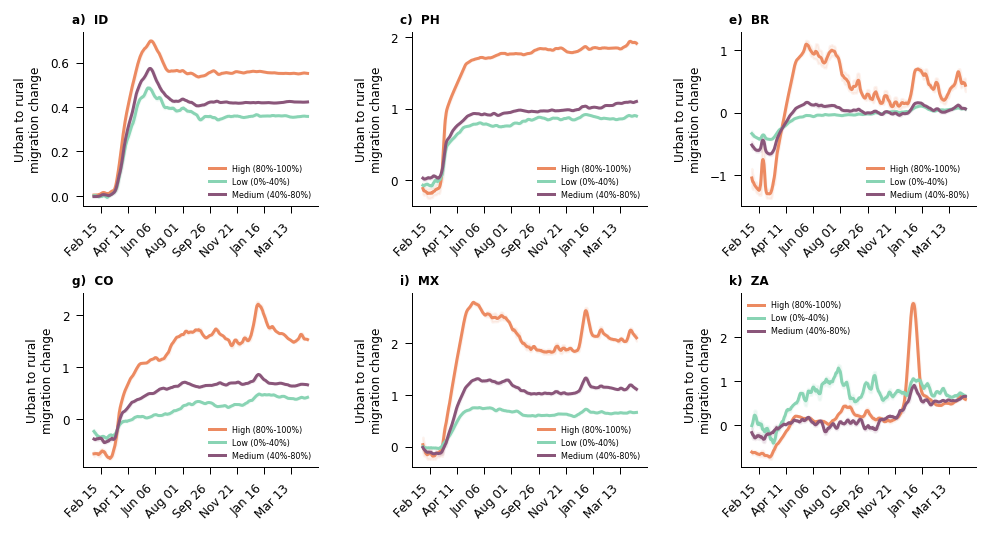

In [0]:
### Cumulated: sum the difference in the number of user going from urban to roral and those coming from rural to urban
### Change: omputes the google change metric over the timeseries (either the plain difference in flows or the cumulated one depending on "cumulated" value)
mw = 7
results = pd.concat([get_migration_results(df_wl,usr_df,state,change=False) for state in countries])
results = results[(results.index>=start_date)&(results.index<=end_date)]

fig1, res1 = plot_migration(results,countries)
fig1.savefig('/dbfs/FileStore/plots/migration_patterns.pdf')
res1.to_csv('/dbfs/FileStore/tables/results_migration_patterns_plot_data.csv',index=False)

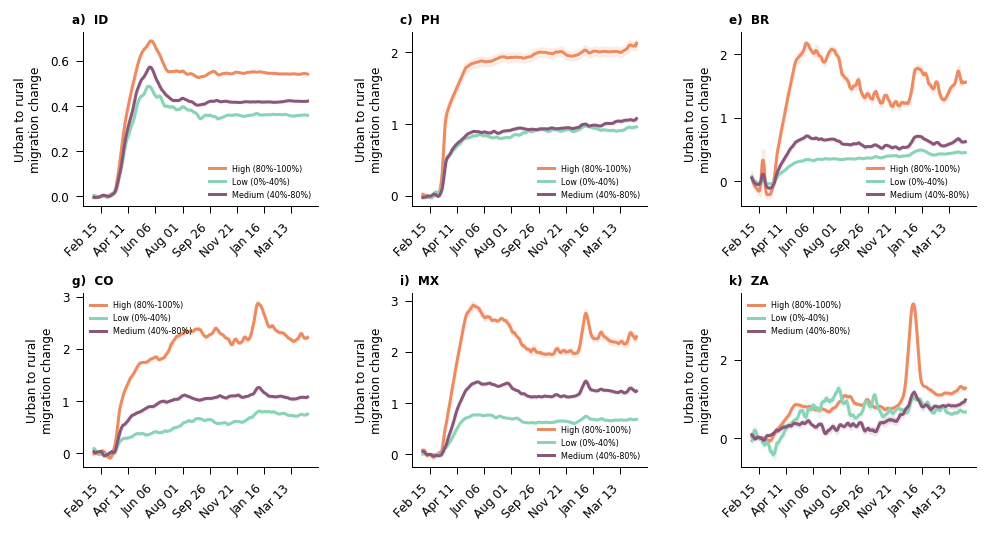

In [0]:
results = pd.concat([get_migration_results(df_wl,usr_df,state,change=True) for state in countries])
fig2, res2 = plot_migration(results,countries)

In [0]:
### Summary statistics from plot:
##  1. average flow before pandemic
##  2. average flow during pandemic
##  3. max value during pandemic
##  4. final value (one week smoothed)
##  5. average difference high-low before
##  6. average difference high-low during
##  7. max. difference high-low
##  8. initial difference high-low
##  9. final difference high-low

stat1 = res1[res1['date']<=end_baseline].groupby('state').mean()
stat2 = res1[(res1['date']>end_baseline)&(res1['date']<='2020-12-31')].groupby('state').mean()
stat3 = res1[(res1['date']>end_baseline)].groupby('state').max()[labels_wealth]
stat4 = res1.iloc[-7:].groupby('state').mean()
diff = (res1[labels_wealth[2]]-res1[labels_wealth[0]]).to_frame('measure')
diff['state'] = res1['state']
diff['date'] = res1['date']
diff['sem'] = np.sqrt(res1[labels_wealth[2]+'_StdErr']**2+res1[labels_wealth[0]+'_StdErr']**2)
stat5 = diff[diff['date']<=end_baseline][['measure','sem']].mean()
stat6 = diff[(diff['date']>end_baseline)&(diff['date']<='2020-12-31')].groupby('state')[['measure','sem']].mean()
stat7 = diff[(diff['date']>end_baseline)].groupby('state')['measure'].max()
stat8 = diff[(diff['date']<=end_baseline)].groupby('state')[['measure','sem']].mean()
stat9 = diff[(diff['date']>end_baseline)].iloc[-7:].groupby('state').mean()